# Multiprocessing

## Comunicación entre procesos

El módulo `multiprocessing` permite la comunicación entre procesos por medio de pipes, colas. Específicamente provee opciones de paso de mensajes por medio de recursos compartidos, pipes para conexiones entre procesos y colas para multiples productores y consumidores.  

In [4]:
import multiprocessing as mp
import time
import os

In [5]:
nums_res = []

def calc_cuad(numeros):
    global nums_res
    for n in numeros:
        print('cuadrado:', n * n )
        nums_res.append(n * n)  

    
nums = range(10)

t = time.time()
p1 = mp.Process(target=calc_cuad, args=(nums,))

p1.start()
p1.join()

print("Tiempo de ejecución: ", time.time()-t)
print("Resultado del proceso:", nums_res)    
print("Finaliza ejecución")
        

cuadrado: 0
cuadrado: 1
cuadrado: 4
cuadrado: 9
cuadrado: 16
cuadrado: 25
cuadrado: 36
cuadrado: 49
cuadrado: 64
cuadrado: 81
Tiempo de ejecución:  0.011628866195678711
Resultado del proceso: []
Finaliza ejecución


Los procesos tienen su propio espacio de memoria. Así, las variables del pograma no se comparten entre procesos. Es necesario crear comunicación entre procesos (IPC) si se desea compartir datos entre procesos.

In [10]:
nums_res = []

def calc_cuad(numeros):
    global nums_res
    for n in numeros:
        print('cuadrado:', n * n )
        nums_res.append(n * n)
        
    print("Resultado del proceso:", nums_res)    

nums = range(10)

t = time.time()
p1 = mp.Process(target=calc_cuad, args=(nums,))

p1.start()
p1.join()

print("Resultado fuera del proceso:", nums_res)

print("Tiempo de ejecución: ", time.time()-t)
print("Finaliza ejecución")

cuadrado: 0
cuadrado: 1
cuadrado: 4
cuadrado: 9
cuadrado: 16
cuadrado: 25
cuadrado: 36
cuadrado: 49
cuadrado: 64
cuadrado: 81
Resultado del proceso: [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
Resultado fuera del proceso: []
Tiempo de ejecución:  0.014773368835449219
Finaliza ejecución


## Memoria compartida

Cuando se realiza una programación concurrente, generalmente es mejor evitar el uso del recursos compartidos en la medida de lo posible. Esto es particularmente cierto cuando se utilizan múltiples procesos.
Sin embargo, si se necesita utilizar algunos datos compartidos, el multiprocesamiento proporciona un medio para hacerlo.

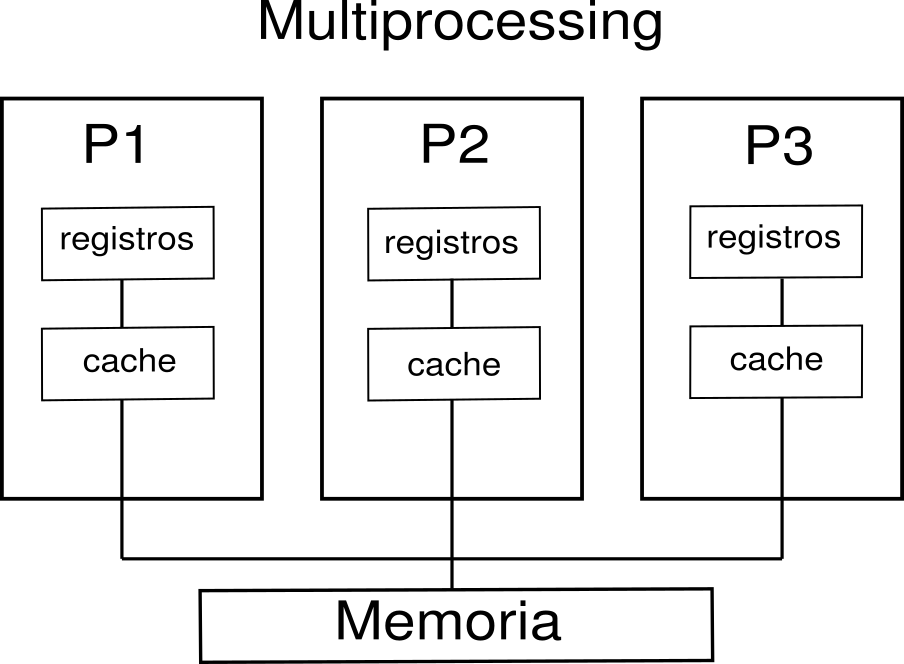

In [6]:
from IPython.display import Image
Image("figures/mem-multiprocessing.png", width=520, height=500)

Los datos se pueden almacenar en un mapa de memoria compartida usando `Array` o `Value`.

In [14]:
nums = [3, 4, 5]
for idx, i in enumerate(nums):
    print(idx, i)


0 3
1 4
2 5


In [17]:
nums = range(10)
for idx, i in enumerate(nums):
    print(idx, i)


0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


Se pueden compartir datos del proceso hijo al proceso padre por medio del método `Array` de multiprocessing.

In [ ]:
def calc_cuad(numeros, result):
    for idx, n in enumerate(numeros):
        result[idx] = n * n
        
    print("Resultado del proceso:", result[:])    

nums = range(10)

t = time.time()
result = mp.Array('i', 10)
p1 = mp.Process(target=calc_cuad, args=(nums,result))

p1.start()
p1.join()

print("Resultado fuera del proceso:", result[:])

print("Tiempo de ejecución: ", time.time()-t)
print("Finaliza ejecución")

También es posible compar valores unitarios del proceso hijo al proceso padre por medio del método `Value` de multiprocessing.

In [3]:
def calc_cuad(numeros, result, val):
    
    val.value = 5.35
    for idx, n in enumerate(numeros):
        result[idx] = n * n
        
    print("Resultado del proceso:", result[:])    

nums = range(10)

t = time.time()
result = mp.Array('i', 10)
val = mp.Value('d', 0.0)
p1 = mp.Process(target=calc_cuad, args=(nums,result, val))

p1.start()
p1.join()

print("Resultado fuera del proceso:", result[:])
print("Resultado fuera del proceso:", val.value)

print("Tiempo de ejecución: ", time.time()-t)
print("Finaliza ejecución")

NameError: name 'time' is not defined

## Pipes

Los *pipes* o tuberías representan una forma de pasar información. Los tipos de *pipes* pueden ser anónimos o con nombre.
Los *pipes* anónimos son métodos de comunicación simple del tipo FIFO, son utilizados para la comunicación interproceso y solo transmiten en una sola direccion a la vez; para una comunicación bidireccional (duplex) se requieren dos *pipes* anónimos. Los *pipes* con  nombre son idénticos a los anónimos con la diferencia que durarán siempre y cuando el sistema operativo tenga activos *pipes* anónimos. 

In [17]:
from multiprocessing import Process, Pipe
 
def f(conn):
    conn.send(['hello world'])
    conn.close()
    
if __name__ == '__main__':
    parent_conn, child_conn = Pipe()
    p = Process(target=f, args=(child_conn,))
    p.start()
    print(parent_conn.recv())   
    p.join()

['hello world']


`Pipe()` devuelve dos objetos de conexión que representan los dos extremos de la tubería. Cada objeto de conexión tiene métodos send() y recv(). Aquí creamos un proceso que imprime el "Hola mundo" de cadena y entonces comparte los datos.

In [29]:
from multiprocessing import Process, Pipe

def worker(conn):
    print(conn.recv())
    conn.send("sent from child process")
    conn.close()

conn1, conn2 = multiprocessing.Pipe()
process = multiprocessing.Process(target=worker, args=(conn2,))
process.start()

conn1.send("sent from main process")
print(conn1.recv())
process.join()

sent from main process
sent from child process


In [26]:
from multiprocessing import Process, Pipe

nombres = ["Carlos", "Renata", "Rebeca", "Sandra", "END"]

def send_msgs(conn, msgs):
    for msg in msgs:
        conn.send(msg)
    conn.close()
    
def recv_msgs(conn):
    
    while 1:
        msg = conn.recv()
        if msg == "END":
            break
        print(msg)
        
parent_conn, child_conn = multiprocessing.Pipe()

p1 = multiprocessing.Process(target=send_msgs, args=(parent_conn, nombres))
p2 = multiprocessing.Process(target=recv_msgs, args=(child_conn,))

p1.start()
p2.start()

p1.join()
p2.join()


Carlos
Renata
Rebeca
Sandra


In [44]:
# import os
# pipeout, pipein = os.pipe()

import os, sys
import multiprocessing

class ChildProcess(multiprocessing.Process):
    
    def __init__(self, pipein):
        super(ChildProcess, self).__init__()
        self.pipein = pipein
        
    def run(self):
        print("Intentando iniciar el pipe")
        self.pipein = os.fdopen(self.pipein, 'w')
        self.pipein.write("Mi código es MX-317")
        self.pipein.close()
        

def main():
    pipeout, pipein = os.pipe()
    
    child = ChildProcess(pipein)
    child.start()
    child.join()
    
    os.close(pipein)
    pipeout = os.fdopen(pipeout)
    
    pipeContent = pipeout.read()
    print("Pipe: {}".format(pipeContent))
    
if __name__== '__main__':
    main()


Intentando iniciar el pipe
Pipe: Mi código es MX-317


`Pipe` Returns a pair (conn1, conn2) of Connection objects representing the ends of a pipe.

If duplex is True (the default) then the pipe is bidirectional. If duplex is False then the pipe is unidirectional: conn1 can only be used for receiving messages and conn2 can only be used for sending messages.

## Colas

La clase `Queue` del módulo de `multiprocessing` facilita la implementación de una cola FIFO para procesos como para subprocesos. Cualquier objetos de Python se puede pasar a través de un objeto queue. Con las colas es posible pasar mensajes de un lado a otro entre procesos.
Es común usar una cola de mensajes para la comunicación entre procesos en lugar de tener recursos compartidos, ya que, si ciertos procesos manejan mal la memoria y los recursos compartidos, corrompiendo algno de estos mientras se comparten los recursos, habrá numerosas consecuencias indeseables e impredecibles. Sin embargo, si un proceso no pudo manejar su mensaje correctamente, otros elementos en la cola permanecerán intactos.

El siguiente diagrama representa las diferencias en la arquitectura entre el uso de una cola de mensajes y los recursos compartidos (específicamente la memoria) para el interproceso.

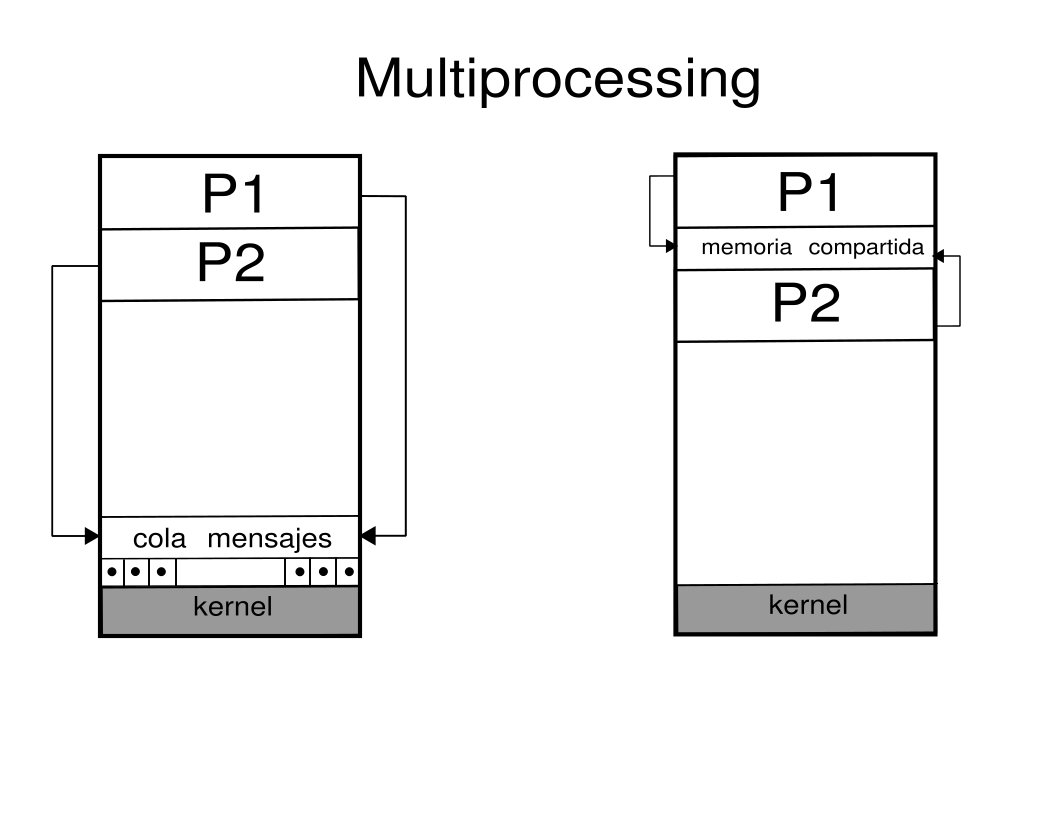

In [10]:
from IPython.display import Image
Image("figures/queue-multiprocessing.png", width=520, height=500)

Veamos un ejemplo sencillo de la creación de una cola por medio de `Queue`:

In [54]:
from multiprocessing import Process, Queue

def f(q):
    q.put([42, None, 'hello'])

if __name__ == '__main__':
    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    print(q.get())    # prints "[42, None, 'hello']"
    p.join()

[42, None, 'hello']


In [55]:
import multiprocessing

def calc_cuad(numeros, q):
    for n in numeros:
        q.put(n * n)

if __name__ == '__main__':

    nums = range(10)
    q = multiprocessing.Queue()
    p = multiprocessing.Process(target=calc_cuad, args=(nums,q))
    
    p.start()
    p.join()
    
    while q.empty() is False:
        print(q.get())

0
1
4
9
16
25
36
49
64
81


In [57]:
import multiprocessing

class MyWorker():
    def __init__(self, x):
        self.x = x

    def process(self):
        pname = multiprocessing.current_process().name
        print('Starting process %s for number %i...' % (pname, self.x))

def work(q):
    worker = q.get()
    worker.process()

if __name__ == '__main__':
    my_queue = multiprocessing.Queue()

    p = multiprocessing.Process(target=work, args=(my_queue,))
    p.start()

    my_queue.put(MyWorker(1))

    my_queue.close()
    my_queue.join_thread()
    p.join()

    print('Done.')

Starting process Process-48 for number 1...
Done.


## Bloqueo

Existen recursos los cuales no se deben acceder al mismo tiempo por dos procesos o más; por lo que es necesario proteger o bloquear el acceso a estos recursos compartidos: memoria, archivos, bases de datos.

In [23]:
import time
import multiprocessing

def deposit(balance):
    for i in range(100):
        time.sleep(0.01)
        balance.value = balance.value + 1
        
def withdraw(balance):
    for i in range(100):
        time.sleep(0.01)
        balance.value = balance.value - 1
    
        
if __name__ == '__main__':
    balance = multiprocessing.Value('i', 200)
    d = multiprocessing.Process(target=deposit, args=(balance,))
    w = multiprocessing.Process(target=withdraw, args=(balance,))
    d.start()
    w.start()
    d.join()
    w.join()
    print(balance.value)

200


In [8]:
import time
import multiprocessing

def deposit(balance, lock):
    for i in range(100):
        time.sleep(0.01)
        lock.acquire()
        balance.value = balance.value + 1
        lock.release()
        
def withdraw(balance, lock):
    for i in range(100):
        time.sleep(0.01)
        lock.acquire()
        balance.value = balance.value - 1
        lock.release()
    
        
if __name__ == '__main__':
    balance = multiprocessing.Value('i', 200)
    lock = multiprocessing.Lock()
    d = multiprocessing.Process(target=deposit, args=(balance, lock))
    w = multiprocessing.Process(target=withdraw, args=(balance, lock))
    d.start()
    w.start()
    d.join()
    w.join()
    print(balance.value)

200


## Distribución de trabajo 

Por medio del método `Pool()` se distribuyen un conjunto de datos entre múltiples procesadores. A través de esta técnica se puede implementar el modelo de programación paralelelo `mapreduce` 

In [6]:
from multiprocessing import Pool

def cuad (n):
    return n * n

if __name__ == "__main__":
    
    datos = [1, 2, 3, 4, 5]
    p = Pool()
    resultado = p.map(cuad, datos)
    print(resultado)

[1, 4, 9, 16, 25]


In [8]:
from multiprocessing import Pool
import time

def suma(n):
    val = 0
    for x in range(1000):
        val += x*x
        
    return val

t = time.time()
result = []
for x in range(100000):
    resultado.append(suma(x))
    
print("Processo serial: ", time.time()-t)

Processo serial:  5.619954347610474


In [11]:
from multiprocessing import Pool
import time

def suma(n):
    val = 0
    for x in range(1000):
        val += x*x    
    return val

if __name__ == "__main__":
    
    t = time.time()
    p = Pool()
    resultado = p.map(suma,range(100000))
    p.close()
    p.join()
    
    print("Processo paralelo: ", time.time()-t)

Processo paralelo:  1.7299787998199463
